In [ ]:
# CC: What about dependency between features when using all of them? It may affect how the effect can be 
# attributed to the cause. How do you take care of that?
# CC: What about one-hot-encoded variables and their importance? These are groups but I think I only saw single-
# variable "effects".
# CC: Opinion: 
# * I would display more of the "hidden" code.
# * I would do less "fancy" stuff, i.e. HTML formatting thingies.
# CC: For comparison, I would like to see simple a random forest using "as raw as possible"-data and then
# compute permutation importance.
# CC: With regards to variable importance, a simple line or bar chart would be nice. Also the "percentage explained".
# CC: Comparison with random sampling would be helpful to put performance into perspective.
# CC: Maybe add note on ratio between number of observations and number of variables?

# Predicting Attrition

In [1]:
import sys
sys.path.insert(0, 'utils/')  # CC: same comment as in other notebook
from utils_attrition import *  # CC: same comment as in other notebook

## Problem description

This notebook accompanies the Online Panel Study 2017 (doi: 10.11587/I7QIYJ) conducted by the Austrian
National Election Study (**AUTNES**). The six wave panel focuses on the Austrian National Parliamentary Election held on 15 October 2017. 

The notebook is aimed to investigate the attrition of survey participants across waves. Sometimes respondents tend to skip the study in the following waves and some of them come back in later waves. However, missing information impairs the quality of panel dataset in general. Thus, we try to predict which participants are more likely to drop the survey. The questions are the following:
* Is there a typical person that leaves? Does it make sense to recruit more participants with certain features?
* Which factors affect attrition? Do their answers indicate whether they will stay?

The approach is to make classification wave-by-wave basis (i.e. taking data from the first wave and use it to predict attrition in the second wave, then use features from the second wave to forecast wave 3, etc). Then we take actual data from latter waves to evaluate models.
We left the proportions between 'dropped' and 'stayed' class the same in both test and train sets (which is important for imbalanced  dataset).

In [2]:
# CC: How do above questions affect random sampling?

### Sneak peak at the data:
Raw data contains many `NaN`s and uninformative feature names:

In [3]:
df_raw = pd.read_csv('data/10017_da_en_v2_0.tab', sep='\t')
df_raw.drop(['version', 'doi', 'id'], axis=1).head(10)

,panelpat,w1_panelist,w2_panelist,w3_panelist,w4_panelist,w5_panelist,w6_panelist,w1_weightd,w2_weightd,w3_weightd,...,w6f_q27x5,w6f_q39,w6f_q40,w6f_q41,w6f_q42,w6f_q42t,w6f_q43x1,w6f_q43x2,w6f_q43x3,w6f_q43x4
0,12.4..,1,1,0,1,0,0,1.45,1.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.....,1,0,0,0,0,0,1.39,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,123456,1,1,1,1,1,1,0.63,0.56,0.65,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
3,1.3456,1,0,1,1,1,1,0.42,NaN,0.43,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
4,1.345.,1,0,1,1,1,0,0.77,NaN,0.73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,123456,1,1,1,1,1,1,0.98,0.83,0.92,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
6,123456,1,1,1,1,1,1,0.63,0.58,0.66,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
7,123456,1,1,1,1,1,1,0.41,0.49,0.52,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
8,123456,1,1,1,1,1,1,1.95,1.70,1.87,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN
9,...456,0,0,0,1,1,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN


Data cleaning and processing is done in [a separate notebook](./data_preparation.ipynb).

# Metrics used

In [4]:
# pick arbitrary wave for demonstration
wave = 3
names = ['drop', 'stay']
personal, political, y = import_data(wave)
horizontal_line(), h2centered(f'Wave {wave}'), y_counter(y)

,panelpat
stayed,2683
dropped,450


(None, None, None)

> The two classes are quite __unbalanced__...

We use different subsets of the independent features to predict attrition in the survey.
In order to evaluate the quality of models and predictions we use different metrics, which are based on confusion matrix:

|                        | Real positive                   | Real negative                   |   |   |
|------------------------|---------------------------------|---------------------------------|---|---|
| **Predicted positive** | <mark>True positive (TP)</mark> | False positive (FP)             |   |   |
| **Predicted negative** | False negative (FN)             | <mark>True negative (TN)</mark> |   |   |
|                        |                                 |                                 |   |   |
|                        |                                 |                                 |   |   |


We computed the following evaluation metrics:

|                   | Measures                                                                                          |   |   |
|-------------------|---------------------------------------------------------------------------------------------------|---|---|
| **Precision**     | How many observations predicted as positive are in fact positive                                  |   |   |
| **Recall**        | How many observations out of all positive observations have we classified as positive             |   |   |
| **Accuracy**      | How many observations, both positive and negative, were correctly classified                      |   |   |

The models were tested with training set and test set (30% of samples are test, seed is not random for results to be comparable).

We store all the performance metrics in df, called **performance**. Each time it is called, we concatenate new results 

# Models used

### Logistic Regression

One of the most well-studied models there are. It has very strong theoretical/statistical backing (if certain conditions are met). Even nonlinear dependencies on features can be modeled by adding the as columns before the fitting process.

In [5]:
def logistic_regression(X_train, y_train, X_test, y_test, names, performance):
    clf = LogisticRegression(max_iter=10000, class_weight='balanced')
    clf.fit(X_train, y_train)

    fancy_output_for_lr(clf.coef_, X_train)
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

### Decision Trees
[Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning) split the data in flow chart like structure and are therefore able to model nonlinear dependences but at the same time remain interpretable.

In [6]:
def decision_tree(X_train, y_train, X_test, y_test, names, performance):
    tree_params = {'min_samples_leaf': [100, 250]}
    clf = GridSearchCV(DecisionTreeClassifier(max_depth=4, class_weight='balanced'), tree_params) 
    clf.fit(X_train, y_train)
    prune_duplicate_leaves(clf.best_estimator_)
    fancy_plotting_for_DT(clf, X_train, names)
    
    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

### Support Vector Machine
A linear model similar to logistic regression but uses a different loss function for training.

In [7]:
def SVM_default(X_train, y_train, X_test, y_test, names, performance):
    clf = LinearSVC(max_iter=10000, class_weight='balanced')
    clf.fit(X_train, y_train)

    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

def RBF_SVM(X_train, y_train, X_test, y_test, names, performance):
    """Kernel Support Vector Machine using a radial basis function."""
    clf = SVC(probability=True, class_weight='balanced')
    clf.fit(X_train, y_train)

    return store_data_for_table(performance, X_train, y_train, X_test, y_test, clf)

def models_without_output(X_train, y_train, X_test, y_test, names, performance):
    """just to plot the performance metrics at the end, without the most important features print"""
    performance = SVM_default(X_train, y_train, X_test, y_test, names, performance)
    performance = RBF_SVM(X_train, y_train, X_test, y_test, names, performance)
    return performance

# ensemble models are omitted due to obtaining similar results as other models with longer waiting times

In total we have 6 waves, the task is to predict attrition of the participants, based on previous waves. However, for demonstration purposes we leave only 1 wave

# Run methods using different features

## Using only personal features

In [8]:
X = personal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Run methods

Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=250)

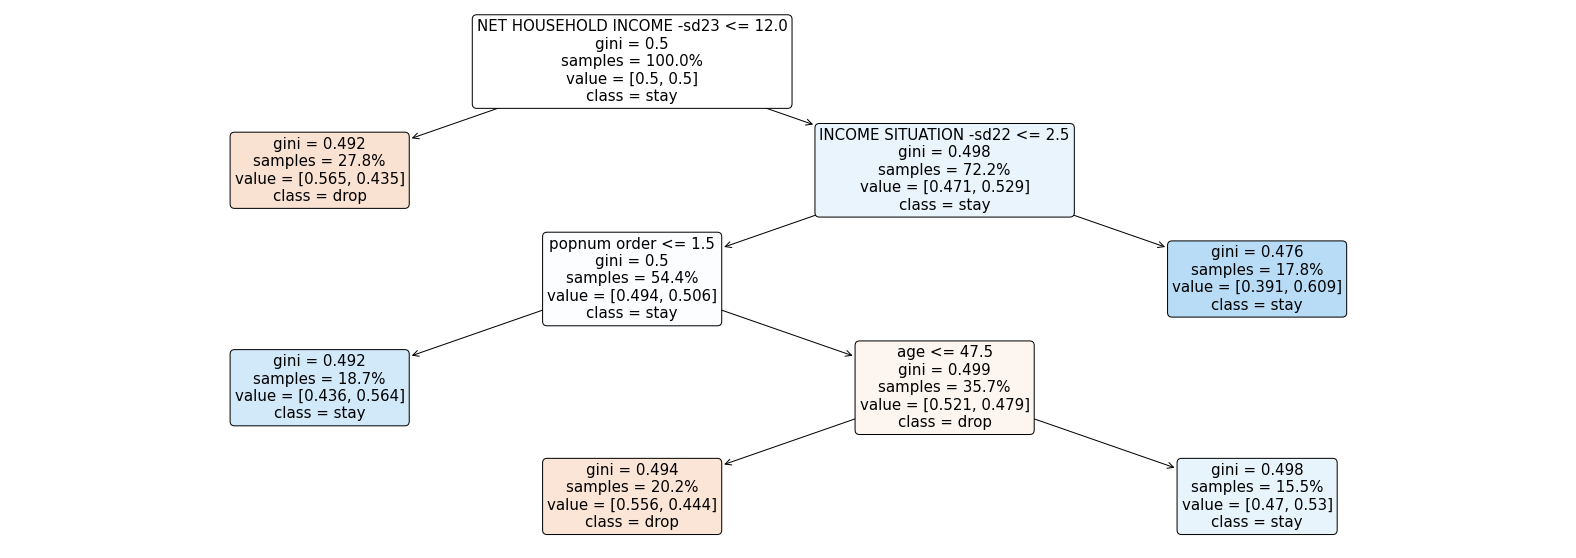

In [9]:
performance = decision_tree(X_train, y_train, X_test, y_test, names, performance)

In [10]:
X_train, X_test = scale_train(X_train, X_test)
performance = logistic_regression(X_train, y_train, X_test, y_test, names, performance)

,coef
CURRENT PERSONAL SITUATION -sd10__5.0,-1.267743
OTHER OCCUPATION -sd12__3.0,1.067922
"Country of birth, mother -sd19__2.0",0.912697
ADDITIONAL OCCUPATION -sd13__2.0,0.896671
RELIGIOUS AFFILIATION -sd8__5.0,-0.892236
GENDER -sd3__3.0,-0.847397
"Country of birth, father -sd20__3.0",-0.783405
ADDITIONAL OCCUPATION -sd13__4.0,-0.742079
OTHER OCCUPATION -sd12__1.0,-0.732565
CURRENT PERSONAL SITUATION -sd10__9.0,0.731425


The sign of the coefficients has a simple interpretation: __negative__ means that a higher value in this feature corresponds to a lower probability to stay - and vice versa.

In [11]:
performance = models_without_output(X_train, y_train, X_test, y_test, names, performance)

## Using All features (personal, political & engineered)

In [12]:
X = pd.concat([personal, political], axis=1)  # CC: At this point is it still clear which were engineered?

# removing redundant features and labels
dte = X.filter(like='_dte', axis=1)
X = X.drop(['participated_only_once', dte.columns[0]], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Run methods

Best classifier from GridSearch:


DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=100)

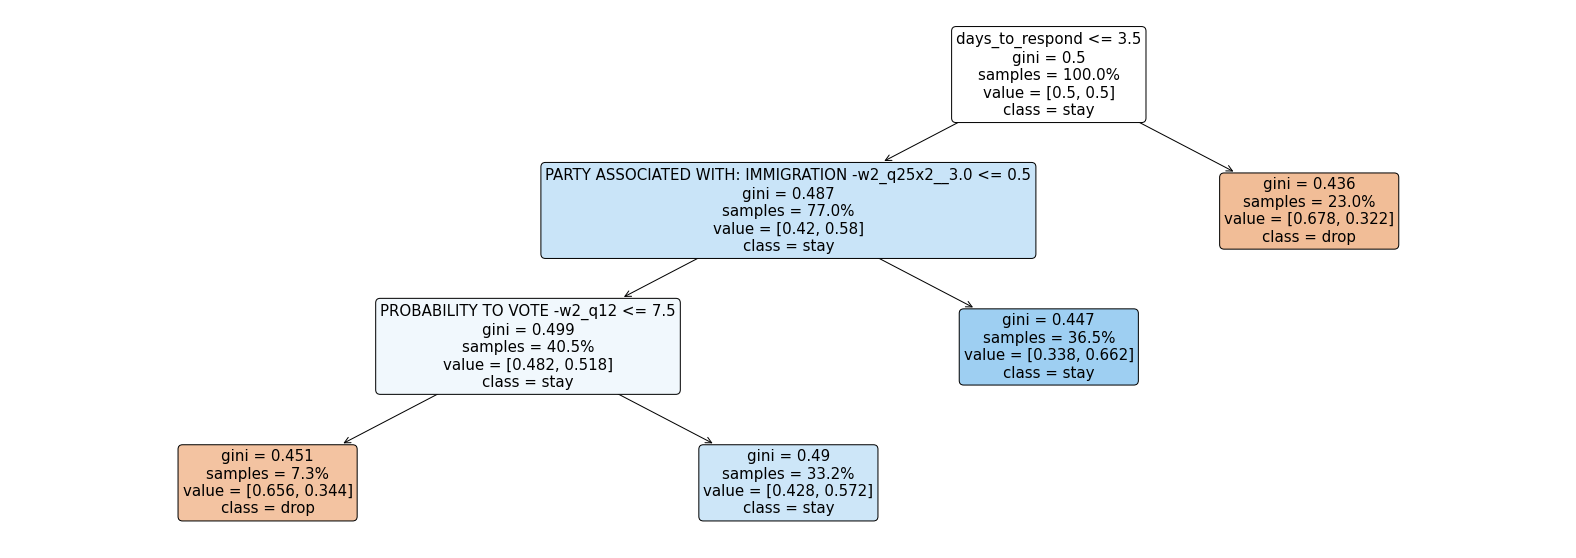

In [13]:
performance = decision_tree(X_train, y_train, X_test, y_test, names, performance)

We see that the some of the most important features for the DT model were:
- how many days it took people to respond to the survey
- and how propable they think they are to vote in the next election

In [14]:
X_train, X_test = scale_train(X_train, X_test)
performance = logistic_regression(X_train, y_train, X_test, y_test, names, performance)

,coef
days_to_respond,-2.325434
dont_know_ratio,-1.822217
PARTY UNITED/DIVIDED - IMMIGRATION: OEVP -w2_q28x2,1.718207
PARTY ASSOCIATED WITH: ENVIRONMENTAL PROTECTION -w2_q25x5__66.0,-1.370192
OTHER OCCUPATION -sd12__1.0,-1.333555
RELIGIOUS AFFILIATION -sd8__5.0,-1.267223
PARTY CHOICE: PROSPECTIVE -w2_q13__8.0,-1.132776
PARTY CHOICE: HYPOTHETICAL -w2_q14__6.0,-1.126633
LIKE-DISLIKE: ULRIKE LUNACEK -w2_q6x4,-1.056932
OTHER OCCUPATION -sd12__3.0,1.056671


> Both, the decision tree model and the logistic regression agree that the `days_to_respond` feature is the most relevant one. The more days it took respondents to answer the survey, the more likely they are to not respond at all in the next wave.

In [15]:
performance = models_without_output(X_train, y_train, X_test, y_test, names, performance)

# Results

![](Precision_recall_accuracy_plots.png)

Although the newly introduced features in the larger dataset (using all questions+engineered features) seemed to be very relevant to the models it is not so clear whether they performed better. 

# References

1. Wagner, Markus, Julian Aichholzer, Jakob-Moritz Eberl, Thomas Meyer, Nicolai Berk, Nico Büttner, Hajo
Boomgaarden, Sylvia Kritzinger and Wolfgang C. Müller (2020). AUTNES Online Panel Study 2017 (SUF
Edition). Vienna: AUSSDA (doi:10.11587/I7QIYJ).

2. Wagner, Markus, Julian Aichholzer, Jakob-Moritz Eberl, Thomas Meyer, Nicolai Berk, Nico Büttner, Hajo
Boomgaarden, Sylvia Kritzinger and Wolfgang C. Müller (2020). AUTNES Online Panel Study 2017 –
Documentation. Vienna: AUSSDA (doi:10.11587/I7QIYJ).